# Calculating EOFs & PCs using ingrid's 'svd' command

## Importing ingrid DataCatalog calculations into notebooks using xarray and pandas

In [1]:
import pandas as pd
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

## First a digression about ingrid and time grids

In [2]:
# Ingrid dods URLs can be used directly into xr.open_dataset(), using decode_times
URL = 'https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/.version4/.anom/X/180/VALUE/Y/0/VALUE/dods'
ds = xr.open_dataset(URL,decode_times=False)
ds

<xarray.Dataset>
Dimensions:  (T: 1971, X: 1, Y: 1, zlev: 1)
Coordinates:
  * zlev     (zlev) float32 0.0
  * T        (T) float32 -1271.5 -1270.5 -1269.5 -1268.5 -1267.5 -1266.5 ...
  * X        (X) float32 180.0
  * Y        (Y) float32 0.0
Data variables:
    anom     (T, zlev, Y, X) float32 ...
Attributes:
    Conventions:  IRIDL

### N.B. time grid trouble from ingrid to xarray
1. it usually works to convert into 'days since' using 'streamgridunitconvert' in ingrid
2. another method is to use 'decode_times=False' and then use pandas to replace the dataset's time grid

In [3]:
# Method 1:
baseURL = 'https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/.version4/.anom/X/180/VALUE/Y/0/VALUE'
# use the ingrid command: 'T (days since 1854-01-01) streamgridunitconvert'
Tconvert = '/T/(days%20since%201854-01-01)streamgridunitconvert'  
URL = baseURL+Tconvert+'/dods'
ds = xr.open_dataset(URL)
ds

<xarray.Dataset>
Dimensions:  (T: 1971, X: 1, Y: 1, zlev: 1)
Coordinates:
  * zlev     (zlev) float32 0.0
  * X        (X) float32 180.0
  * Y        (Y) float32 0.0
  * T        (T) datetime64[ns] 1854-01-16T12:00:00 1854-02-15 ...
Data variables:
    anom     (T, zlev, Y, X) float32 ...
Attributes:
    Conventions:  IRIDL

In [5]:
# Method 2:
ds = xr.open_dataset('https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/.version4/.anom/X/180/VALUE/Y/0/VALUE/dods'
                     ,decode_times=False)
ds['T'] = pd.date_range('1/1/1854', periods=ds.anom.shape[0], freq='MS').shift(14, freq='D')
ds

<xarray.Dataset>
Dimensions:  (T: 1971, X: 1, Y: 1, zlev: 1)
Coordinates:
  * zlev     (zlev) float32 0.0
  * T        (T) datetime64[ns] 1854-01-15 1854-02-15 1854-03-15 1854-04-15 ...
  * X        (X) float32 180.0
  * Y        (Y) float32 0.0
Data variables:
    anom     (T, zlev, Y, X) float32 ...
Attributes:
    Conventions:  IRIDL

In [6]:
ingridsnippet = """
 SOURCES .NOAA .NCDC .ERSST .version4 .anom zlev removeGRID
  T (Jan\ 1958) (Dec\ 2014) RANGE
  Y -40 40 RANGE
  X 120 290 RANGE
  yearly-anomalies
  T 12 boxAverage
  T (days\ since\ 1960-01-01) streamgridunitconvert
"""
snip = ' '.join(ingridsnippet.split()).replace('\ ','%20').replace(' ','/')
nc_url = 'https://iridl.ldeo.columbia.edu/'+snip+'/dods'
print(nc_url)
ds_anom = xr.open_dataset(nc_url)
ds_anom

https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/.version4/.anom/zlev/removeGRID/T/(Jan%201958)/(Dec%202014)/RANGE/Y/-40/40/RANGE/X/120/290/RANGE/yearly-anomalies/T/12/boxAverage/T/(days%20since%201960-01-01)/streamgridunitconvert/dods


<xarray.Dataset>
Dimensions:  (T: 57, X: 86, Y: 41)
Coordinates:
  * X        (X) float32 120.0 122.0 124.0 126.0 128.0 130.0 132.0 134.0 ...
  * Y        (Y) float32 -40.0 -38.0 -36.0 -34.0 -32.0 -30.0 -28.0 -26.0 ...
  * T        (T) datetime64[ns] 1958-07-02T12:00:00 1959-07-02T12:00:00 ...
Data variables:
    anom     (T, Y, X) float32 ...
Attributes:
    Conventions:  IRIDL

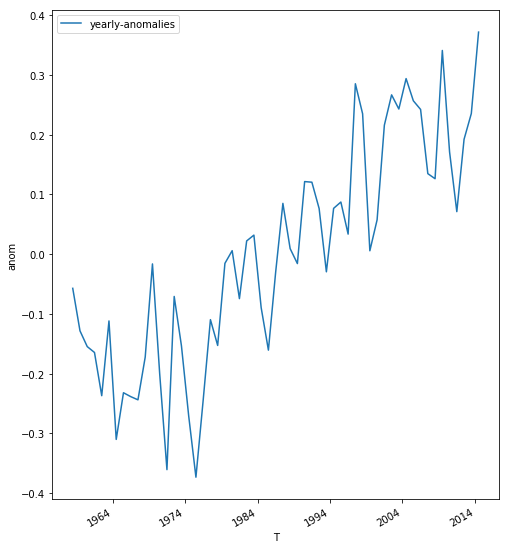

In [7]:
plt.figure(figsize=(8, 10))
ds_anom.anom.mean(dim=['X','Y']).plot(label="yearly-anomalies")
plt.legend()

### get the EOFs (spatial patterns)

In [8]:
ingridsnippet = """
 SOURCES .NOAA .NCDC .ERSST .version4 .anom zlev removeGRID
  T (Jan\ 1958) (Dec\ 2014) RANGE
  Y -40 40 RANGE
  X 120 290 RANGE
  yearly-anomalies
  T 12 boxAverage
  {Y cosd sqrt}[Y X][T]svd
  ev 1 4 RANGE .Ss
"""
snip = ' '.join(ingridsnippet.split()).replace('\ ','%20').replace(' ','/')
nc_url = 'https://iridl.ldeo.columbia.edu/'+snip+'/dods'
print(nc_url)
ds_anom['Ss'] = xr.open_dataset(nc_url).Ss
ds_anom

https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/.version4/.anom/zlev/removeGRID/T/(Jan%201958)/(Dec%202014)/RANGE/Y/-40/40/RANGE/X/120/290/RANGE/yearly-anomalies/T/12/boxAverage/{Y/cosd/sqrt}[Y/X][T]svd/ev/1/4/RANGE/.Ss/dods


<xarray.Dataset>
Dimensions:  (T: 57, X: 86, Y: 41, ev: 4)
Coordinates:
  * X        (X) float32 120.0 122.0 124.0 126.0 128.0 130.0 132.0 134.0 ...
  * Y        (Y) float32 -40.0 -38.0 -36.0 -34.0 -32.0 -30.0 -28.0 -26.0 ...
  * T        (T) datetime64[ns] 1958-07-02T12:00:00 1959-07-02T12:00:00 ...
  * ev       (ev) float32 1.0 2.0 3.0 4.0
Data variables:
    anom     (T, Y, X) float32 -0.47467473 -0.47218543 -0.4508575 -0.4223885 ...
    Ss       (ev, Y, X) float64 ...
Attributes:
    Conventions:  IRIDL

### get the Principal Components (PCs)

In [10]:
ingridsnippet = """
 SOURCES .NOAA .NCDC .ERSST .version4 .anom zlev removeGRID
  T (Jan\ 1958) (Dec\ 2014) RANGE
  Y -40 40 RANGE
  X 120 290 RANGE
  yearly-anomalies
  T 12 boxAverage
  {Y cosd sqrt}[Y X][T]svd
  ev 1 4 RANGE .Ts
"""
snip = ' '.join(ingridsnippet.split()).replace('\ ','%20').replace(' ','/')
nc_url = 'https://iridl.ldeo.columbia.edu/'+snip+'/dods'
print(nc_url)
ds2 = xr.open_dataset(nc_url,decode_times=False)

ds_anom['T'] = pd.date_range('1/1/1958', periods=ds2.Ts.shape[1], freq='AS-JUL')
ds_anom['Ts'] = (['ev','T'],ds2.Ts)

https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/.version4/.anom/zlev/removeGRID/T/(Jan%201958)/(Dec%202014)/RANGE/Y/-40/40/RANGE/X/120/290/RANGE/yearly-anomalies/T/12/boxAverage/{Y/cosd/sqrt}[Y/X][T]svd/ev/1/4/RANGE/.Ts/dods


In [11]:
ds_anom['T']

<xarray.DataArray 'T' (T: 57)>
array(['1958-07-01T00:00:00.000000000', '1959-07-01T00:00:00.000000000',
       '1960-07-01T00:00:00.000000000', '1961-07-01T00:00:00.000000000',
       '1962-07-01T00:00:00.000000000', '1963-07-01T00:00:00.000000000',
       '1964-07-01T00:00:00.000000000', '1965-07-01T00:00:00.000000000',
       '1966-07-01T00:00:00.000000000', '1967-07-01T00:00:00.000000000',
       '1968-07-01T00:00:00.000000000', '1969-07-01T00:00:00.000000000',
       '1970-07-01T00:00:00.000000000', '1971-07-01T00:00:00.000000000',
       '1972-07-01T00:00:00.000000000', '1973-07-01T00:00:00.000000000',
       '1974-07-01T00:00:00.000000000', '1975-07-01T00:00:00.000000000',
       '1976-07-01T00:00:00.000000000', '1977-07-01T00:00:00.000000000',
       '1978-07-01T00:00:00.000000000', '1979-07-01T00:00:00.000000000',
       '1980-07-01T00:00:00.000000000', '1981-07-01T00:00:00.000000000',
       '1982-07-01T00:00:00.000000000', '1983-07-01T00:00:00.000000000',
       '1984-07-01T0

### plots 

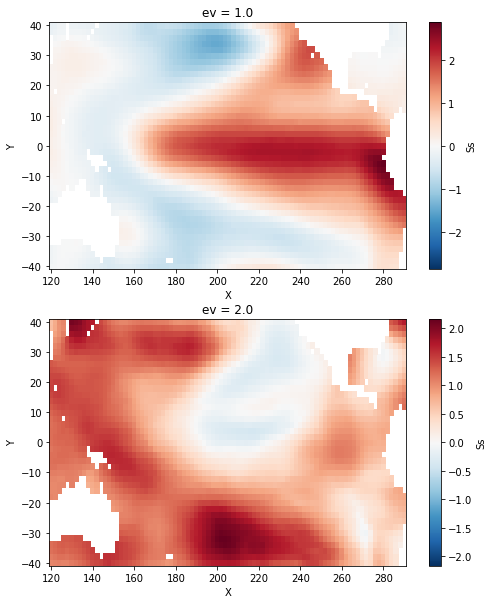

In [12]:
plt.figure(figsize=(8, 10))
plt.subplot(211)
ds_anom.Ss[0].plot()
plt.subplot(212)
ds_anom.Ss[1].plot()

Text(0.5,1,'PC2')

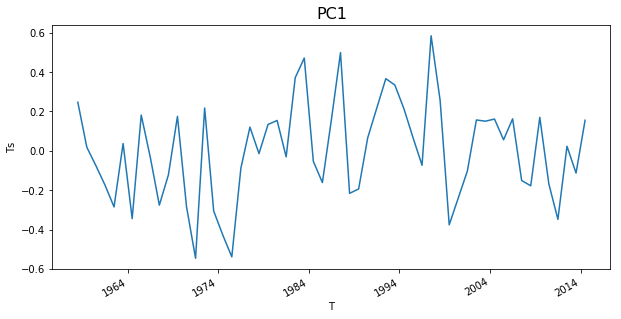

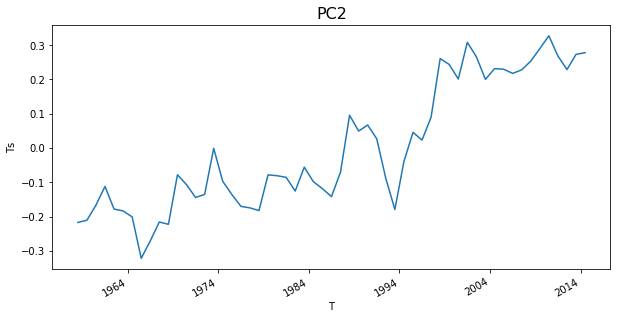

In [13]:
ds_anom.Ts[0].plot(figsize=(10,5)); plt.title('PC1',fontsize=16)
ds_anom.Ts[1].plot(figsize=(10,5)); plt.title('PC2',fontsize=16)

In [14]:
ds_anom.to_netcdf('ingrid_EOF.nc')

In [ ]:
#ds_anom.X
#ds_anom.Ss[0].plot.contour(levels=np.arange(-3,3,.1))
#plt.plot(ds_anom.X,0*ds_anom.X)